# Anticipez les besoins en consommation électrique de bâtiments

Pascaline Grondein

Début : 04/04/2022

<i/> Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation. </i>

<i/>Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées. Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.</i>

https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

### Table of Contents

* [I. Sélection des variables et individus pertinents](#chapter1)
    * [1. Variables pertinentes](#section_1_1)
    * [2. Individus pertinents](#section_1_2)
    * [3. Split train set/test set](#section_1_3)
* [II. Nettoyage](#chapter2)
    * [1. Filtrage des valeurs manquantes](#section_2_1)
        * [a. X_train/test](#section_2_1_1)
        * [b. Targets](#section_2_1_2)
    * [2. Traitement valeurs manquantes](#section_2_2)
        * [a. X_train/test](#section_2_2_1)
        * [b. Targets](#section_2_2_2)
    * [3. Doublons](#section_2_3)
    * [4. Traitement outliers](#section_2_4)
        * [a. X_train/test](#section_2_4_1)
        * [b. Targets](#section_2_4_2)
* [III. Analyse exploratoire sur training set](#chapter3)
* [IV. Préparation des données](#chapter4)

In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import json

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

data_2015 = pd.read_csv('2015-building-energy-benchmarking.csv')
data_2016 = pd.read_csv('2016-building-energy-benchmarking.csv')

print('Le fichier data_2015 comporte',data_2015.shape[0],'lignes et',data_2015.shape[1],'colonnes.')
print('Le fichier data_2016 comporte',data_2016.shape[0],'lignes et',data_2016.shape[1],'colonnes.')

Le fichier data_2015 comporte 3340 lignes et 47 colonnes.
Le fichier data_2016 comporte 3376 lignes et 46 colonnes.


Création d'une fonction pour comparer des listes (de variables, notamment).

In [435]:
def compare_list(l1,l2):
    l1.sort()
    l2.sort()
    if(l1==l2):
        return "Equal"
    else:
        return "Non equal"

# <a class="anchor" id="chapter1">I. Sélection des variables et split train/test</a>

On récupère la description des variables à partir d'un fichier json.

In [437]:
f = open('socrata_metadata_2016-building-energy-benchmarking.json')
var_2016 = json.load(f)
var_2016= pd.DataFrame(data=var_2016['columns'])

## <a class="anchor" id="section_1_1">1. Variables pertinentes</a>

In [438]:
var_2016_description = var_2016[['name','dataTypeName','description']]
pd.set_option('display.max_colwidth', None)
var_2016_description

,name,dataTypeName,description
0,OSEBuildingID,number,A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
1,DataYear,number,Calendar year (January-December) represented by each data record.
2,BuildingType,text,City of Seattle building type classification.
3,PrimaryPropertyType,text,"The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager."
4,PropertyName,text,Official or common property name as entered in EPA’s Portfolio Manager.
5,Address,text,Property street address
6,City,text,Property city
7,State,text,Property state
8,ZipCode,number,Property zip
9,TaxParcelIdentificationNumber,text,Property King County PIN


Les variables identifiées comme pertinentes pour la problématique sont : 
 - **OSEBuildingID** : (index) A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
 - **BuildingType** : City of Seattle building type classification.
 - **PrimaryPropertyType** : The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
 - **CouncilDistrictCode**
 - **Neighborhood**
 - **YearBuilt** : Year in which a property was constructed or underwent a complete renovation.
 - **PropertyGFATotal** : Total building and parking gross floor area.
 - **ENERGYSTARScore** : An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.
 - **SiteEUI(kBtu/sf)** : Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.
 - **SiteEUIWN(kBtu/sf)**
 - **SourceEUI(kBtu/sf)** : Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.
 - **SourceEUIWN(kBtu/sf)**
 - **SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.
 - **SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).
 - **Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).
 - **NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).
 - **TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.

In [440]:
var_per = ['OSEBuildingID','BuildingType','PrimaryPropertyType',"CouncilDistrictCode",
           'Neighborhood','YearBuilt','PropertyGFATotal','ENERGYSTARScore','SiteEnergyUse(kBtu)',
           'SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)',
           'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions']
data_2016_subset = data_2016[var_per]

La variable OSEBuildingID est unique pour chaque bâtiment, on la définit comme index pour la suite.

In [441]:
data_2016_subset = data_2016_subset.set_index('OSEBuildingID')

## <a class="anchor" id="section_1_2">2. Individus pertinents</a> 

Puisqu'on ne s’intéresse qu'aux émissions des bâtiments non destinés à l’habitation, un tri en fonction du type de bâtiment est nécessaire, avec la variable Building Type.

Regardons la répartition de la variables Building Type, pour connaître la proportion de bâtiments utilisés comme habitation.

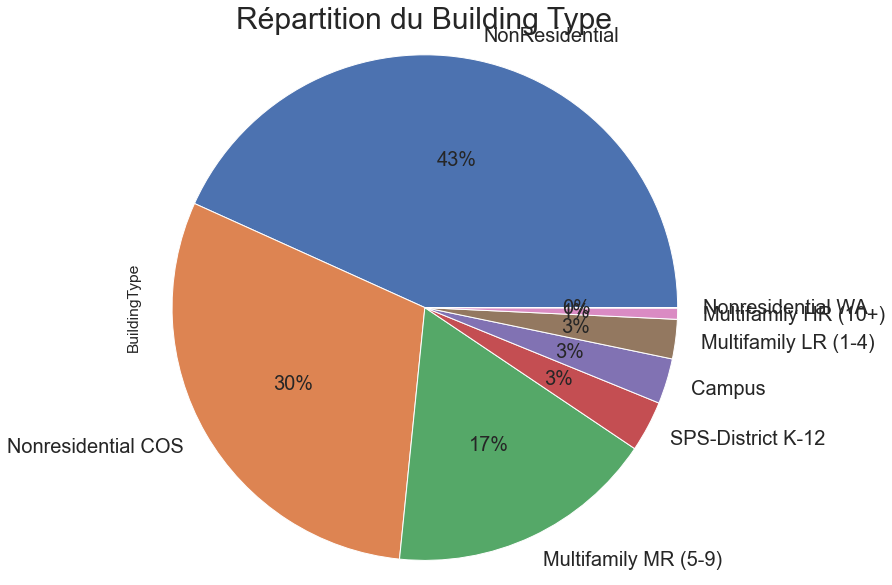

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [442]:
plot = data_2016_subset['BuildingType'].value_counts(normalize=True).plot(
    kind='pie',y='BuildingType',
    labels = data_2016_subset['BuildingType'].unique(), 
    autopct='%1.0f%%',figsize=(10, 10),fontsize = 20, legend = False)

plot.set_title('Répartition du Building Type',fontsize = 30)
plt.axis('equal') 
plt.show()
data_2016_subset['BuildingType'].unique()

Pour écarter les bâtiments utlisés comme habitation, il faut écarter les individus dans les catégories Multifamily, donc enlever environ 21% des données. 

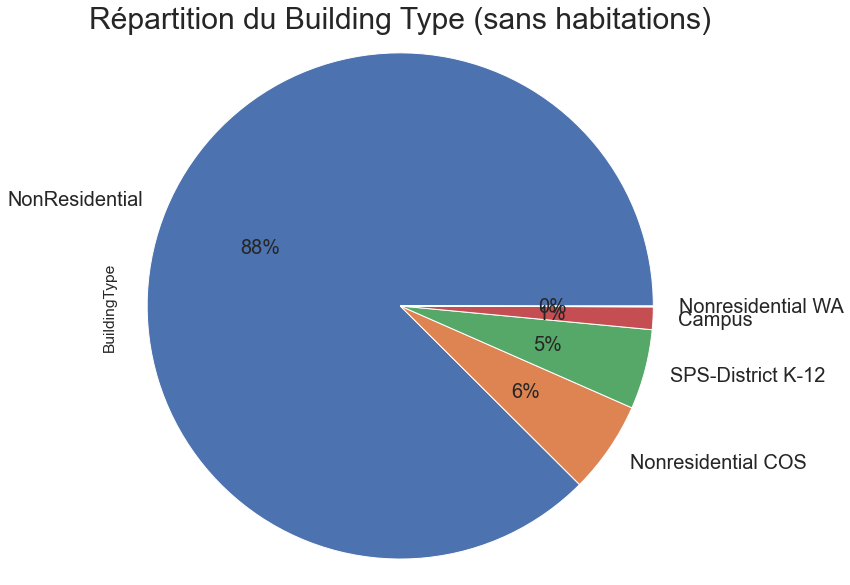

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [443]:
data_2016_subset=data_2016_subset[~data_2016_subset['BuildingType'].str.contains(r'Multifamily( )')]

plot = data_2016_subset['BuildingType'].value_counts(normalize=True).plot(
    kind='pie', y = 'BuildingType',labels = data_2016_subset['BuildingType'].unique(),
    autopct='%1.0f%%',figsize=(10, 10),fontsize = 20, legend = False)

plot.set_title('Répartition du Building Type (sans habitations)',fontsize = 30)
plt.axis('equal') 
plt.show()
data_2016_subset['BuildingType'].unique()

In [444]:
print('Le fichier data_2016_subset comporte',data_2016_subset.shape[0],
      'lignes et',data_2016_subset.shape[1],'colonnes.')

Le fichier data_2016_subset comporte 1668 lignes et 17 colonnes.


## <a class="anchor" id="section_1_3">3. Split trainset/test set</a>

Après sélection des variables et individus pertinents, on effectue la séparation entre jeu de données entraînement et test.

In [445]:
# On récupère les labels
targets = ['TotalGHGEmissions','SiteEnergyUse(kBtu)']
y = data_2016_subset[targets] 
X = data_2016_subset.drop(targets,axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(X_train.shape)
print(X_test.shape)

(1334, 15)
(334, 15)


# <a class="anchor" id="chapter2">II. Nettoyage</a>

##  <a class="anchor" id="section_2_1">1. Filtrage des valeurs manquantes</a>

On commence par récupèrer les données de 2015 pour remplacer certaines valeurs manquantes de 2016.

In [447]:
data_2015.rename(columns={"Zip Codes": "ZipCode", "GHGEmissions(MetricTonsCO2e)": "TotalGHGEmissions",
                          "GHGEmissionsIntensity(kgCO2e/ft2)": "GHGEmissionsIntensity"})
data_2015_subset = data_2015.drop(columns = [col for col in data_2015 if col not in var_per])
data_2015_subset=data_2015_subset[~data_2015_subset['BuildingType'].str.contains(r'Multifamily( )')]
print('Le fichier data_2015_subset comporte',data_2015_subset.shape[0],'lignes et',
      data_2015_subset.shape[1],'colonnes.')

Le fichier data_2015_subset comporte 1650 lignes et 17 colonnes.


OSEBuildingID              0
BuildingType               0
PrimaryPropertyType        0
CouncilDistrictCode        0
Neighborhood               0
YearBuilt                  0
PropertyGFATotal           0
ENERGYSTARScore          533
SiteEUI(kBtu/sf)           7
SiteEUIWN(kBtu/sf)         7
SourceEUI(kBtu/sf)         7
SourceEUIWN(kBtu/sf)       7
SiteEnergyUse(kBtu)        7
SteamUse(kBtu)             7
Electricity(kBtu)          7
NaturalGas(kBtu)           7
Outlier                 1619
dtype: int64

On définit ensuite la fonction de filtrage des variables en fonction du pourcentage de valeurs manquantes. On garde la liste des individus retirés pour les enlever également dans les targets. 

In [448]:
def filtrage_vm(df_train, df_test, df_bis, pct_seuil_col, pct_seuil_row): 
    #df_train
    #df_test
    #df_bis = dataframe bis pour remplacer les possibles valeurs manquantes
    #pct_seuil_col : seuil de remplissage pour les colonnes en %
    #pct_seuil_row : seuil de remplissage pour les lignes en %
    
    
    #1.COMBINAISON VALEURS DF/DFBis
    df_train = df_train.fillna(df_bis)
    df_test = df_test.fillna(df_bis)

    
    #2.VALEURS MANQUANTES VARIABLES
    print('VALEURS MANQUANTES - Filtrage Variables')
    print('   ')
      
    #On collecte le nombre de valeurs manquantes par variable pour train/test
    nb_na_train = df_train.isnull().sum() 
    nb_na_test = df_test.isnull().sum()
    
    print ('Le dataframe d\'entraînement comporte',df_train.shape[0],'lignes et',df_train.shape[1],
           'colonnes, ainsi que',nb_na_train.sum(),'valeurs manquantes.' )
    print ('Le dataframe de test comporte',df_test.shape[0],'lignes et',df_test.shape[1],
           'colonnes, ainsi que',nb_na_test.sum(),'valeurs manquantes.' )

    
    #On calcule le pourcentage de valeurs manquantes par variables pour train/test
    index_train = df_train.index
    pct_remplissage_train = pd.DataFrame((100-((nb_na_train/len(index_train))*100)).astype(int), 
                                   columns=['Pourcentage de remplissage (%)']) 
    
    index_test = df_test.index
    pct_remplissage_test = pd.DataFrame((100-((nb_na_test/len(index_test))*100)).astype(int), 
                                   columns=['Pourcentage de remplissage (%)']) 

    #On trace les pourcentages de valeurs manquantes pour train/test
    sns.set_style("whitegrid")
    
    pct_remplissage_train.sort_values('Pourcentage de remplissage (%)', 
                                ascending=False).plot.barh(x=None, y=None,xlim = [0,100],legend=False,
                                                           figsize = (13,13))
    plt.title("Pourcentage de remplissage (%) pour X_train",fontsize = 25)
    plt.xticks(rotation=30, horizontalalignment="center",fontsize = 15)
    plt.yticks(fontsize = 15)
    line_seuil = plt.axvline(x=pct_seuil_col, color='r', linestyle='-')
    plt.legend([line_seuil],['Seuil de remplissage'],prop={"size":15})
    plt.show()
    
    pct_remplissage_test.sort_values('Pourcentage de remplissage (%)', 
                                ascending=False).plot.barh(x=None, y=None,xlim = [0,100],legend=False,
                                                           figsize = (13,13))
    plt.title("Pourcentage de remplissage (%) pour X_test",fontsize = 25)
    plt.xticks(rotation=30, horizontalalignment="center",fontsize = 15)
    plt.yticks(fontsize = 15)
    line_seuil = plt.axvline(x=pct_seuil_col, color='r', linestyle='-')
    plt.legend([line_seuil],['Seuil de remplissage'],prop={"size":15})
    plt.show()
    
    #on retire les variables avec un taux de remplissage inf au seuil dans train/test
    vardrop_train = pct_remplissage_train.loc[pct_remplissage_train
                                              ['Pourcentage de remplissage (%)'] < pct_seuil_col]
    vardrop_test = pct_remplissage_test.loc[pct_remplissage_test
                                              ['Pourcentage de remplissage (%)'] < pct_seuil_col]
    
    
    df_train = df_train.drop(vardrop_train.index, axis = 1)
    df_test = df_test.drop(vardrop_train.index, axis = 1)

    
    print('   ')
    
    
    
    
    #3.VALEURS MANQUANTES INDIVIDUS
    print('----------')
    print('   ')
    print('VALEURS MANQUANTES - Filtrage individus')
    print('   ')
    
    #On collecte le nombre de valeurs manquantes par individu pour train/test
    nb_na_row_train = df_train.isnull().sum(axis=1)
    nb_na_row_test = df_test.isnull().sum(axis=1)
    
    print ('Le dataframe X_train comporte désormais',df_train.shape[0],
           'lignes et',df_train.shape[1],'colonnes, ainsi que',nb_na_row_train.sum(),'valeurs manquantes.' )
    print ('Le dataframe X_test comporte désormais',df_test.shape[0],
           'lignes et',df_test.shape[1],'colonnes, ainsi que',nb_na_row_test.sum(),'valeurs manquantes.' )

    print('   ')

    #On calcule le pourcentage de valeurs manquantes par lignes pour train/test
    columns_train = df_train.columns
    columns_test = df_test.columns
    
    pct_remplissage_row_train = pd.DataFrame((100-((nb_na_row_train/len(columns_train))*100)).astype(int), 
                                       columns=['Pourcentage de remplissage (%)'])
    pct_remplissage_row_test = pd.DataFrame((100-((nb_na_row_test/len(columns_test))*100)).astype(int), 
                                       columns=['Pourcentage de remplissage (%)']) 
    
    
    #on retire les lignes avec un taux de remplissage inf au seuil pour train/test
    rowdrop_train = pct_remplissage_row_train.loc[pct_remplissage_row_train
                                                  ['Pourcentage de remplissage (%)'] < pct_seuil_row]
    rowdrop_test = pct_remplissage_row_test.loc[pct_remplissage_row_test
                                                  ['Pourcentage de remplissage (%)'] < pct_seuil_row]
    
    if (len(rowdrop_train) == 0) & (len(rowdrop_test) == 0) :
        print('Aucun individu ne possède un taux de remplissage inférieur à',pct_seuil_row,
              '% pour les variables sélectionnées.')
    if (len(rowdrop_train) > 1) or (len(rowdrop_test) > 1) :
        print(len(rowdrop_train)+len(rowdrop_train),' individu(s) a/ont un taux de remplissage sous',pct_seuil_row,
              '% pour les variables sélectionnées.')

    df_train = df_train.drop(rowdrop_train.index, axis = 0)
    df_test = df_test.drop(rowdrop_test.index, axis = 0)
        
    
    return df_train,df_test, rowdrop_train, rowdrop_test

###  <a class="anchor" id="section_2_1_1">a. X_train/test</a>

On applique la fonction de filtrage à X_train/test.

VALEURS MANQUANTES - Filtrage Variables
   
Le dataframe d'entraînement comporte 1334 lignes et 15 colonnes, ainsi que 1716 valeurs manquantes.
Le dataframe de test comporte 334 lignes et 15 colonnes, ainsi que 413 valeurs manquantes.


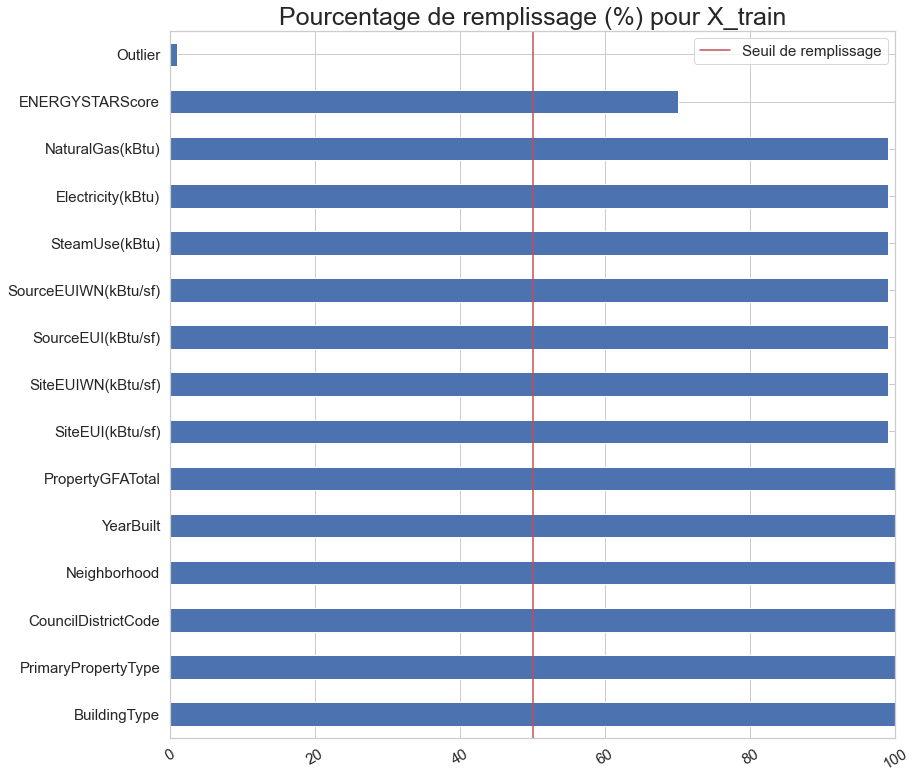

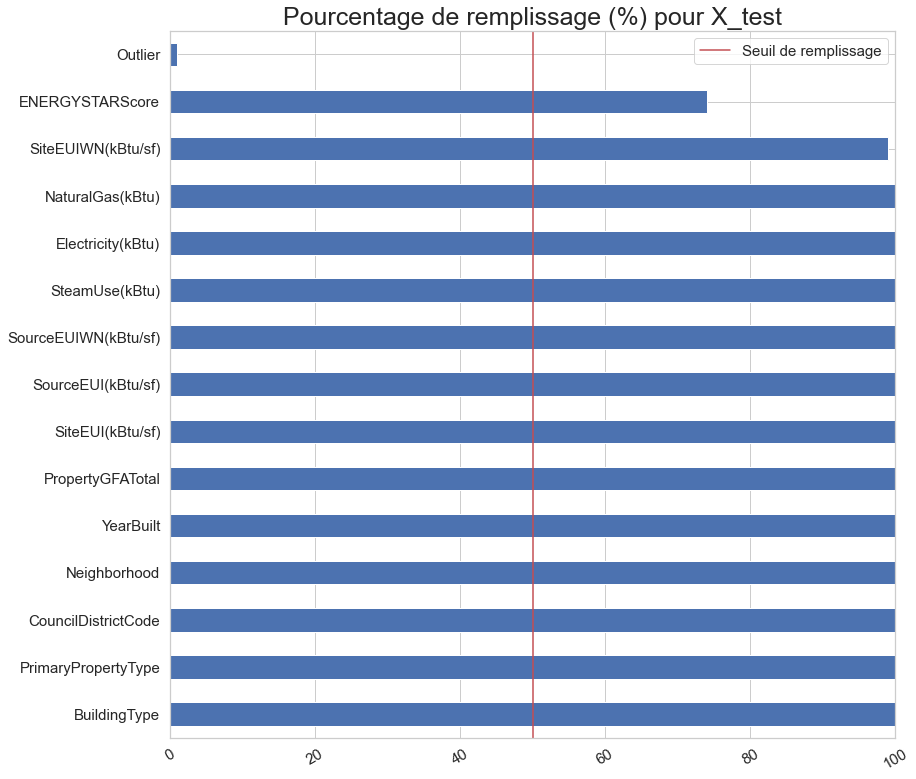

   
----------
   
VALEURS MANQUANTES - Filtrage individus
   
Le dataframe X_train comporte désormais 1334 lignes et 14 colonnes, ainsi que 404 valeurs manquantes.
Le dataframe X_test comporte désormais 334 lignes et 14 colonnes, ainsi que 85 valeurs manquantes.
   
4  individu(s) a/ont un taux de remplissage sous 50 % pour les variables sélectionnées.


In [449]:
X_train, X_test, rowdrop_train, rowdrop_test = filtrage_vm(X_train,X_test,data_2015_subset,
                                                           pct_seuil_col = 50, pct_seuil_row = 50)

### <a class="anchor" id="section_2_1_2">b. Targets</a>

Vérifions si les targets ont des valeurs manquantes.

In [450]:
y_train.isnull().sum()

TotalGHGEmissions      2
SiteEnergyUse(kBtu)    2
dtype: int64

In [451]:
y_test.isnull().sum()

TotalGHGEmissions      0
SiteEnergyUse(kBtu)    0
dtype: int64

Quelques valeurs sont manquantes et seront traitées plus loin.

On fait en sorte d'enlever dans les targets les individus non présents dans X_train/test. Puis, on vérifie que les mêmes individus sont considérés.

In [454]:
y_train = y_train.drop(rowdrop_train.index, axis = 0)
y_test = y_test.drop(rowdrop_test.index, axis = 0)
print(compare_list(list(X_train.index),list(y_train.index)))
print(compare_list(list(X_test.index), list(y_test.index)))

Equal
Equal


## <a class="anchor" id="section_2_2">2. Traitement valeurs manquantes</a>

Après avoir écarté les variables trop peu renseignées, on traite les valeurs manquantes des variables toujours considérées. On définit la fonction pour le traitement des variables manquantes. 

In [455]:
def traitement_vm(X_train, X_test,vm):
    #vm : 0 si remplacement par med_train, 1 si remplacement par VM pour str col

    str_ = list(X_train.select_dtypes(include=['O']).columns)
    num_ = list(X_train._get_numeric_data())
    
    
    
    for column in num_:
        med = X_train[column].median()
        X_train[column] = X_train[column].fillna(med)
        X_test[column] = X_test[column].fillna(med)
          
    if vm == 0:  
        for column in str_:
            X_train[column] = X_train[column].fillna(X_train[column].mode())
            X_test[column] = X_test[column].fillna(X_train[column].mode())
            
    if vm == 1: 
        for column in str_:
            
            plt.figure(figsize=(10,8))
            X_train[column].value_counts(normalize=True).plot(kind='bar')
            plt.title('Répartition de {} avant traitement'.format(column),fontsize = 25)
            plt.xticks(fontsize = 15)
            plt.yticks(fontsize = 15)
            plt.xlabel('',fontsize = 25)
            plt.ylabel('',fontsize = 25)
            plt.show() 

            
            X_train[column] = X_train[column].fillna('VM')
            X_test[column] = X_test[column].fillna('VM')
            
            plt.figure(figsize=(10,8))
            X_train[column].value_counts(normalize=True).plot(kind='bar')
            plt.title('Répartition de {} après traitement'.format(column),fontsize = 25)
            plt.xticks(fontsize = 15)
            plt.yticks(fontsize = 15)
            plt.xlabel('',fontsize = 25)
            plt.ylabel('',fontsize = 25)
            plt.show() 
            
            print('   ')
            print('-------------')
            print('   ')
    
    
    return X_train,X_test

###  <a class="anchor" id="section_2_2_1">a. X_train/test</a>

On applique la fonction de traitement des valeurs manquantes à X_train/test.

In [456]:
X_train,X_test = traitement_vm(X_train,X_test,vm=0)

### <a class="anchor" id="section_2_2_2">b. Targets</a>

Les targets possèdent des valeurs manquantes, que l'ont remplacent par la médiane. 

In [457]:
med_train = y_train.median()
for col in y_train.columns:
    y_train[col] = y_train[col].fillna(med_train[col])
    y_train.isnull().sum()
    y_test[col] = y_test[col].fillna(med_train[col])
    y_test.isnull().sum()

In [458]:
y_train.isnull().sum()

TotalGHGEmissions      0
SiteEnergyUse(kBtu)    0
dtype: int64

In [459]:
y_test.isnull().sum()

TotalGHGEmissions      0
SiteEnergyUse(kBtu)    0
dtype: int64

## <a class="anchor" id="section_2_3">3. Doublons</a> 

In [460]:
def doublon(df): 
    
    dup = df.loc[df.duplicated(keep=False),:]
    print('Le dataframe comporte',len(dup),'doublons.')
    if len(dup) != 0:
        df = df.drop_duplicates()
    
    return df

In [461]:
X_train = doublon(X_train)

Le dataframe comporte 0 doublons.


In [462]:
X_test = doublon(X_test)

Le dataframe comporte 0 doublons.


## <a class="anchor" id="section_2_4">4. Traitement outliers</a> 

### <a class="anchor" id="section_2_4_1">a. X_train/test</a>

Afin de mettre en place un traitement des outliers pour les features, il est important en premier lieu d'analyser les variables.

Pour regarder les distributions des variables numériques, je mets en commun X_train/test le temps de l'analyse.

In [463]:
X = pd.concat([X_train,X_test],axis = 0)

In [464]:
X.describe()

,CouncilDistrictCode,YearBuilt,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,1666.000000,1666.000000,1.666000e+03,1666.000000,1666.000000,1666.000000,1666.000000,1666.000000,1.666000e+03,1.666000e+03,1.666000e+03
mean,4.355342,1961.956783,1.189350e+05,68.534814,72.136795,74.556363,175.829892,178.090876,5.125726e+05,5.843493e+06,1.970845e+06
std,2.191389,32.737659,2.975279e+05,24.211685,74.031337,75.007512,185.932121,185.918749,5.513944e+06,2.079673e+07,9.370814e+06
min,1.000000,1900.000000,1.128500e+04,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,-1.154170e+05,0.000000e+00
25%,2.000000,1930.000000,2.950050e+04,60.000000,33.700001,35.400002,76.450001,79.325003,0.000000e+00,7.213255e+05,0.000000e+00
50%,4.000000,1965.000000,4.928950e+04,75.000000,51.850000,53.900002,130.949997,134.150002,0.000000e+00,1.611881e+06,4.982630e+05
75%,7.000000,1989.000000,1.057750e+05,84.000000,81.649998,85.199997,203.950001,205.700001,0.000000e+00,4.847589e+06,1.520000e+06
max,7.000000,2015.000000,9.320156e+06,100.000000,834.400024,834.400024,2620.000000,2620.000000,1.349435e+08,6.570744e+08,2.979090e+08


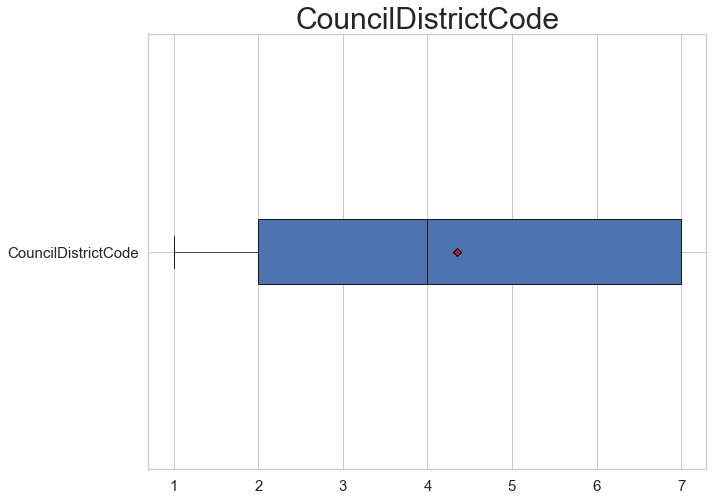

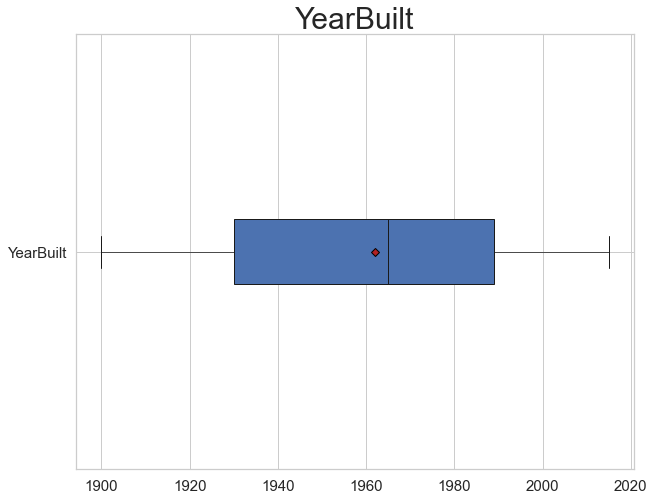

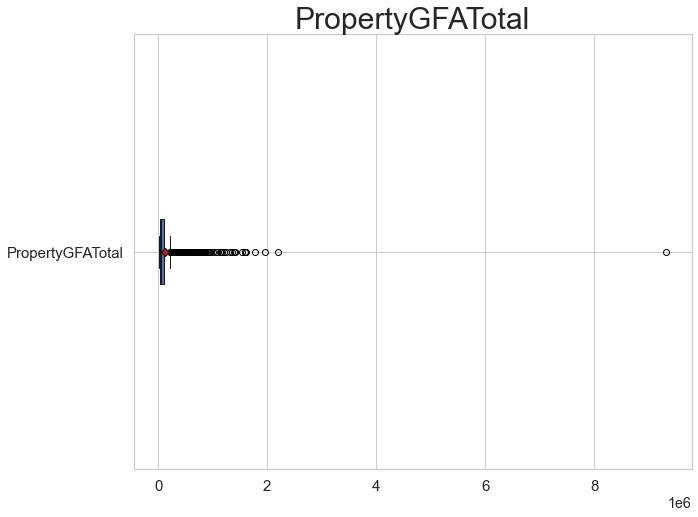

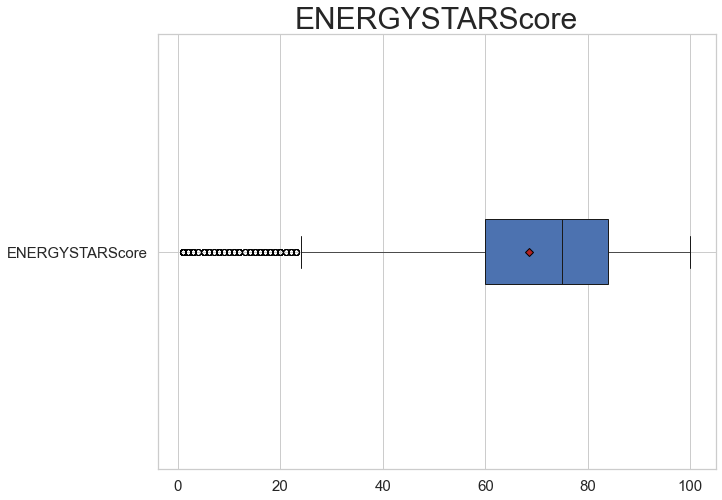

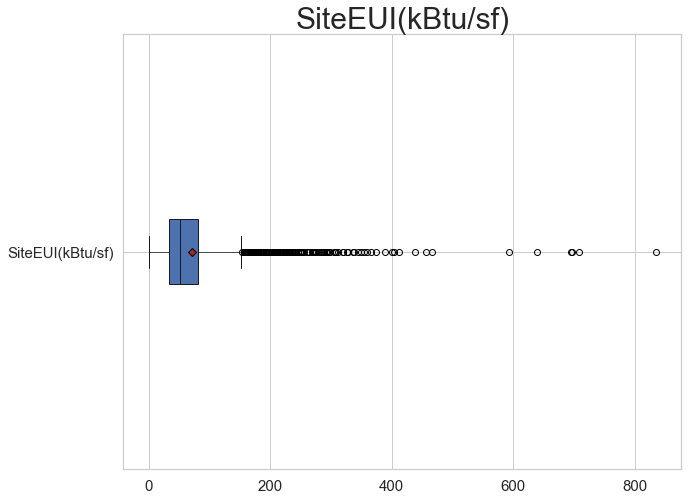

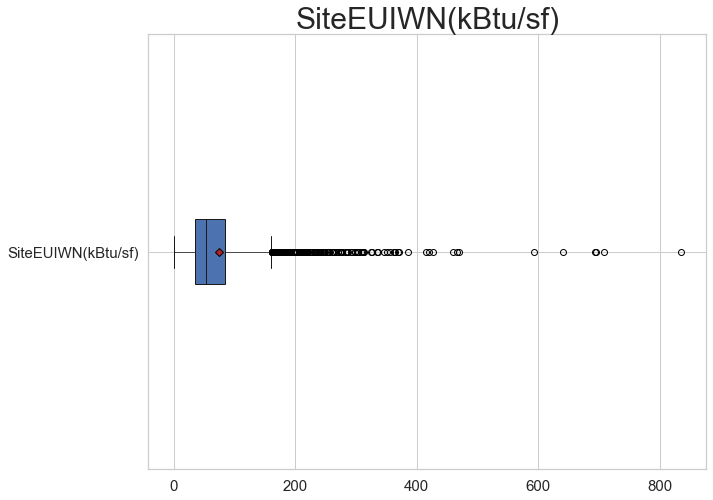

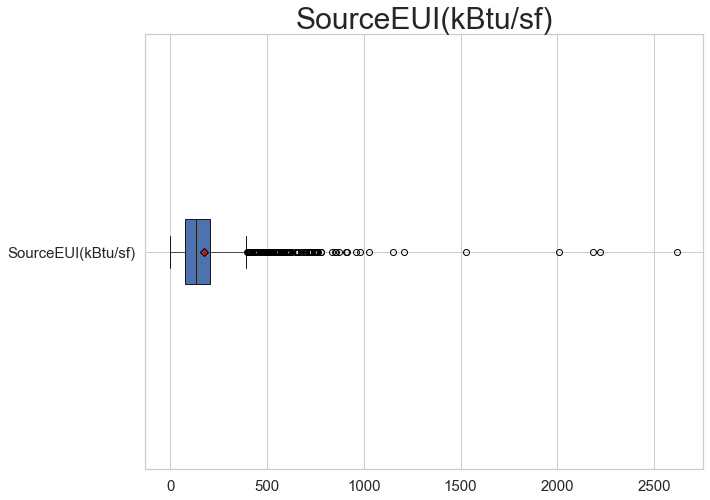

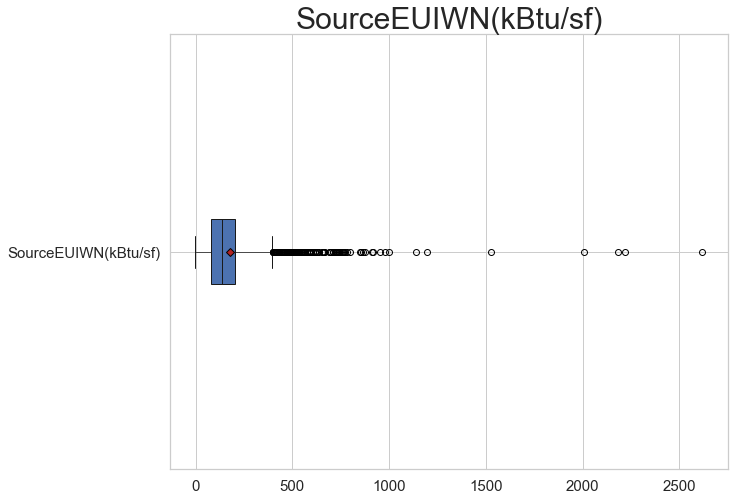

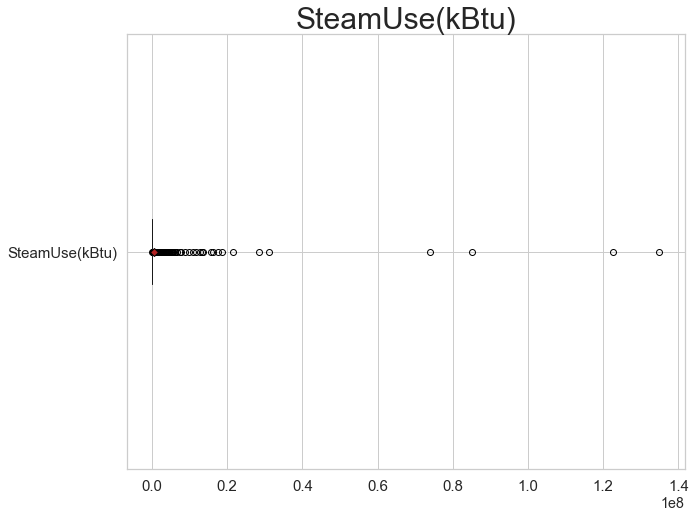

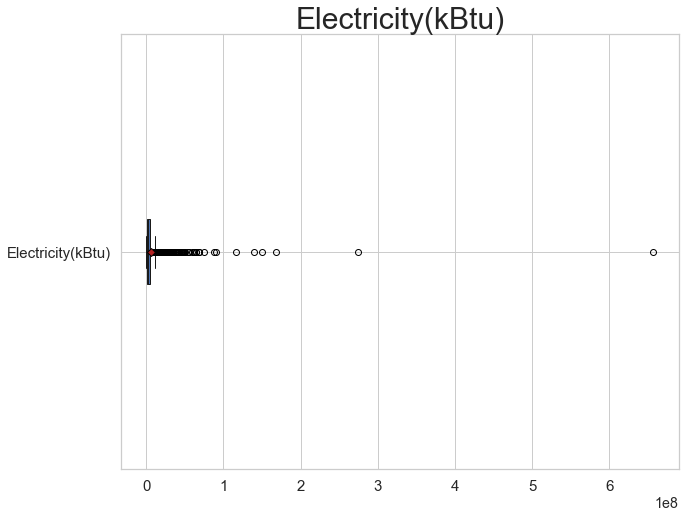

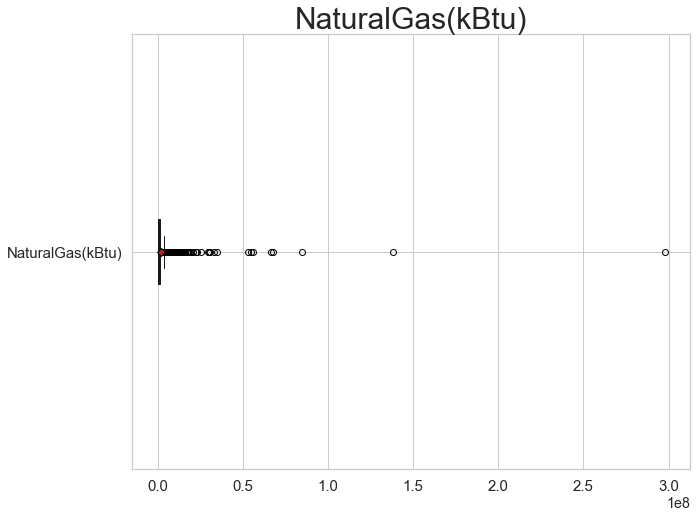

In [465]:
boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=1, color='k')
meanprops = dict(marker='D', markeredgecolor='black',markerfacecolor='firebrick')
sns.set_style("whitegrid")

num_ = list(X._get_numeric_data())

for col in num_ :
    
    plt.figure(figsize=(10,8))
    
    X.boxplot(column=col,boxprops = boxprops,showfliers=True, medianprops=medianprops,vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.title(col,fontsize = 30)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.xlabel('',fontsize = 25)
    plt.ylabel('',fontsize = 25)

    plt.show()

Les variables YearBuilt, CouncilDistrictCode, et EnergyStarScore ne semblent pas avoir de valeurs aberrantes. Les années sont bien comprises entre 1900 et 2015, CouncilDistrictCode entre 1 et 7, et EnergyStarScore entre 0 et 100.

Cependant, certaines variables présentent des valeurs inférieures ou égales à 0. Il est donc nécessaire d'appliquer un traitement des outliers, avec capping. 

In [466]:
def outlier(df_train,df_test,low,lower_percentile,higher_percentile): 
    #low : limite basse
    #higher_percentile : limite haute
    
    #VALEURS ABERRANTES
    print('----------')
    print('   ')
    print('VALEURS ABERRANTES')
    print('   ')
    print('---Avant traitement---')
    display(df_train.describe())
    display(df_test.describe())
    
    #TRAITEMENT FLOAT
    list_float = list(df_train.select_dtypes('float').columns)
    list_float.remove('ENERGYSTARScore')
    
    cap = df_train[list_float].quantile([lower_percentile,higher_percentile])
    display(cap)
    
      
    for column in list_float:
        substring = 'EUI'
        if substring in column:
            
            low_eui = cap[column].values[0]
            df_train.loc[df_train[column] <= low_eui,column] = low_eui
            df_test.loc[df_test[column] <= low_eui,column] = low_eui
        
        
        df_train.loc[df_train[column] < low,column] = low
        df_test.loc[df_test[column] < low,column] = low

        high = cap[column].values[1]
        df_train.loc[df_train[column] > high,column] = high
        df_test.loc[df_test[column] > high,column] = high
        

    print('   ')
    print('   ')
    print('---Après traitement---')
    display(df_train.describe())
    display(df_test.describe())
    
    
    return df_train,df_test

In [467]:
X_train,X_test = outlier(X_train,X_test,low = 0,lower_percentile = 0.05,higher_percentile = 0.95)

----------
   
VALEURS ABERRANTES
   
---Avant traitement---


,CouncilDistrictCode,YearBuilt,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,1332.000000,1332.000000,1.332000e+03,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1.332000e+03,1.332000e+03,1.332000e+03
mean,4.349099,1961.412162,1.205276e+05,69.172673,72.720796,75.104204,178.755631,181.099700,5.544763e+05,5.903314e+06,1.731333e+06
std,2.175036,33.213364,3.201430e+05,23.668419,76.378705,77.241995,195.129489,195.028008,6.059469e+06,2.239313e+07,5.811409e+06
min,1.000000,1900.000000,1.128500e+04,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,-1.154170e+05,0.000000e+00
25%,2.000000,1929.000000,2.962800e+04,62.000000,33.850001,35.900002,76.900002,79.775002,0.000000e+00,7.295642e+05,0.000000e+00
50%,4.000000,1965.000000,5.003650e+04,75.000000,52.099998,54.299999,133.199997,136.000000,0.000000e+00,1.664614e+06,5.141630e+05
75%,7.000000,1989.000000,1.037505e+05,84.000000,81.300003,83.724998,204.999996,205.999996,0.000000e+00,4.860998e+06,1.530812e+06
max,7.000000,2015.000000,9.320156e+06,100.000000,834.400024,834.400024,2620.000000,2620.000000,1.349435e+08,6.570744e+08,1.381912e+08


,CouncilDistrictCode,YearBuilt,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,334.00000,334.000000,3.340000e+02,334.000000,334.000000,334.000000,334.000000,334.000000,3.340000e+02,3.340000e+02,3.340000e+02
mean,4.38024,1964.128743,1.125839e+05,65.991018,69.807784,72.371557,164.161976,166.091617,3.454593e+05,5.604924e+06,2.926022e+06
std,2.25859,30.718985,1.813981e+05,26.149890,63.867686,65.400761,143.161621,143.592500,2.285701e+06,1.257557e+07,1.740482e+07
min,1.00000,1900.000000,1.315700e+04,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.00000,1941.750000,2.935350e+04,56.250000,33.349999,34.924999,75.950001,77.725000,0.000000e+00,6.430140e+05,0.000000e+00
50%,4.00000,1966.000000,4.621600e+04,75.000000,50.450001,52.150002,123.750000,127.549999,0.000000e+00,1.419572e+06,4.179605e+05
75%,7.00000,1988.000000,1.132990e+05,82.000000,83.674997,87.300003,199.174999,202.674999,0.000000e+00,4.816039e+06,1.446404e+06
max,7.00000,2015.000000,1.400000e+06,100.000000,465.500000,467.000000,909.599976,911.500000,2.843888e+07,1.504763e+08,2.979090e+08


,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
0.05,10.420000,10.110000,26.655001,26.055000,0.000000,212503.20,0.0
0.95,219.804997,223.379998,519.900000,523.734998,889409.178125,21450268.45,6394497.3


   
   
---Après traitement---


,CouncilDistrictCode,YearBuilt,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,1332.000000,1332.000000,1.332000e+03,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1.332000e+03,1.332000e+03
mean,4.349099,1961.412162,1.205276e+05,69.172673,67.650357,69.960007,165.821235,168.336659,52586.706665,4.126773e+06,1.231885e+06
std,2.175036,33.213364,3.201430e+05,23.668419,52.882526,53.560393,127.041186,127.210328,204176.768156,5.583834e+06,1.766559e+06
min,1.000000,1900.000000,1.128500e+04,1.000000,10.420000,10.110000,26.655001,26.055000,0.000000,0.000000e+00,0.000000e+00
25%,2.000000,1929.000000,2.962800e+04,62.000000,33.850001,35.900002,76.900002,79.775002,0.000000,7.295642e+05,0.000000e+00
50%,4.000000,1965.000000,5.003650e+04,75.000000,52.099998,54.299999,133.199997,136.000000,0.000000,1.664614e+06,5.141630e+05
75%,7.000000,1989.000000,1.037505e+05,84.000000,81.300003,83.724998,204.999996,205.999996,0.000000,4.860998e+06,1.530812e+06
max,7.000000,2015.000000,9.320156e+06,100.000000,219.804997,223.379998,519.900000,523.734998,889409.178125,2.145027e+07,6.394497e+06


,CouncilDistrictCode,YearBuilt,PropertyGFATotal,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu)
count,334.00000,334.000000,3.340000e+02,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,3.340000e+02,3.340000e+02
mean,4.38024,1964.128743,1.125839e+05,65.991018,67.421706,69.835629,159.717395,161.800449,52511.506683,4.261957e+06,1.220467e+06
std,2.25859,30.718985,1.813981e+05,26.149890,53.587674,54.390482,123.292225,123.430639,199397.030953,6.108721e+06,1.812170e+06
min,1.00000,1900.000000,1.315700e+04,1.000000,10.420000,10.110000,26.655001,26.055000,0.000000,0.000000e+00,0.000000e+00
25%,2.00000,1941.750000,2.935350e+04,56.250000,33.349999,34.924999,75.950001,77.725000,0.000000,6.430140e+05,0.000000e+00
50%,4.00000,1966.000000,4.621600e+04,75.000000,50.450001,52.150002,123.750000,127.549999,0.000000,1.419572e+06,4.179605e+05
75%,7.00000,1988.000000,1.132990e+05,82.000000,83.674997,87.300003,199.174999,202.674999,0.000000,4.816039e+06,1.446404e+06
max,7.00000,2015.000000,1.400000e+06,100.000000,219.804997,223.379998,519.900000,523.734998,889409.178125,2.145027e+07,6.394497e+06


###  <a class="anchor" id="section_2_4_2">b. Targets</a>

Pour le bon fonctionnement des modèles, il est important de vérifier que les valeurs des targets sont cohérentes. Il s'agit ici de mesure d'énergie, elles ne peuvent donc pas être égale ou inférieures à 0.

In [468]:
display('y_train',y_train.describe())
display('y_test',y_test.describe())

'y_train'

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1332.000000,1.332000e+03
mean,175.904339,8.303679e+06
std,673.961863,3.076030e+07
min,-0.800000,0.000000e+00
25%,20.735000,1.260807e+06
50%,49.765000,2.598999e+06
75%,142.052500,6.968646e+06
max,12307.160000,8.739237e+08


'y_test'

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,334.000000,3.340000e+02
mean,221.140539,8.973341e+06
std,1005.069258,2.812714e+07
min,0.000000,0.000000e+00
25%,17.490000,1.139542e+06
50%,49.365000,2.339374e+06
75%,147.142500,6.113028e+06
max,16870.980000,4.483853e+08


Onbservons la distribution des targets.

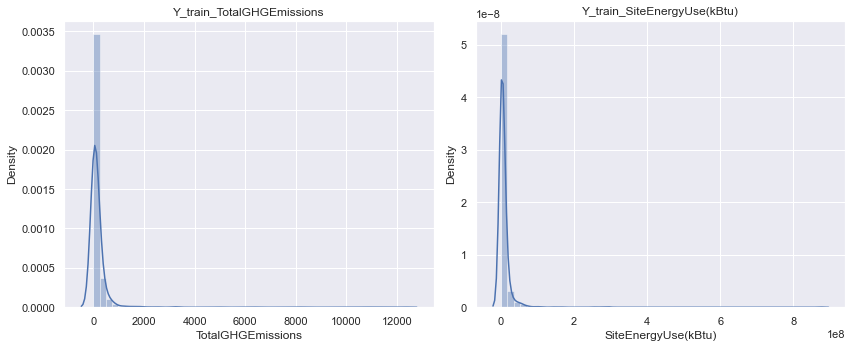

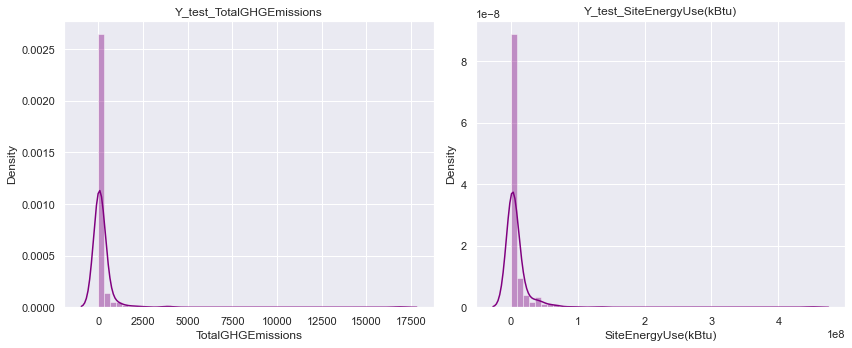

In [470]:
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

sns.set_theme()
fig = plt.figure(figsize=(12,5))

for i in y_train.columns:
    
    plt.subplot(a, b, c)
    plt.title('Y_train_{}'.format(i))
    plt.xlabel(i)
    sns.distplot(y_train[i])
    c = c + 1
    
plt.tight_layout()
plt.show()

c = 1
fig = plt.figure(figsize=(12,5))

for i in y_test.columns:
    
    plt.subplot(a, b, c)
    plt.title('Y_test_{}'.format(i))
    plt.xlabel(i)
    sns.distplot(y_test[i],color='purple')
    c = c + 1

plt.tight_layout()
plt.show()

Certaines valeurs sont en effet ingérieures ou égales à 0, il est intéressant d'appliquer un capping pour ces valeurs, remplacer toute valeur inférieure ou égale à 0 par la valeur au premier quantile.

In [471]:
for col in y_train.columns:
    
    #low = y_train[col].quantile(0.025)
    low = 2
    
    y_train.loc[y_train[col] <= low,col] = low
    y_test.loc[y_test[col] <= low,col] = low
    
display(y_train.describe())
display(y_test.describe())

,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,1332.000000,1.332000e+03
mean,175.932080,8.303679e+06
std,673.954668,3.076030e+07
min,2.000000,2.000000e+00
25%,20.735000,1.260807e+06
50%,49.765000,2.598999e+06
75%,142.052500,6.968646e+06
max,12307.160000,8.739237e+08


,TotalGHGEmissions,SiteEnergyUse(kBtu)
count,334.000000,3.340000e+02
mean,221.166856,8.973341e+06
std,1005.063484,2.812714e+07
min,2.000000,2.000000e+00
25%,17.490000,1.139542e+06
50%,49.365000,2.339374e+06
75%,147.142500,6.113028e+06
max,16870.980000,4.483853e+08


Après ce capping, il est possible d'observer la distribution des targets en semi-log.

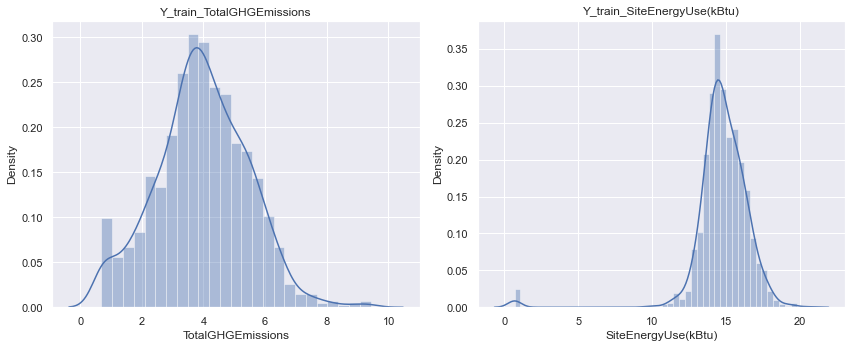

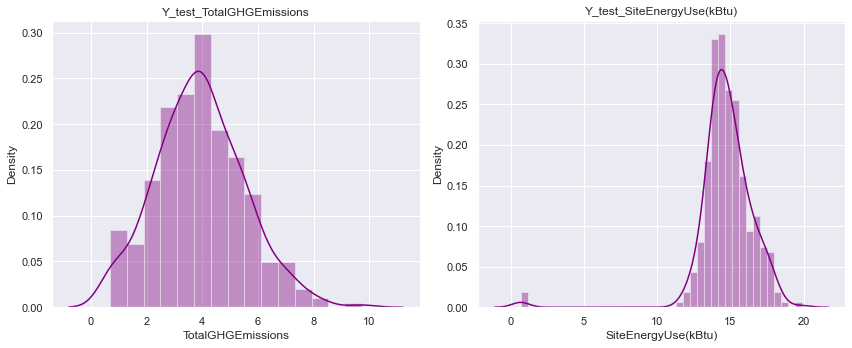

In [472]:
a = 1  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

sns.set_theme()
fig = plt.figure(figsize=(12,5))

for i in y_train.columns:
    
    plt.subplot(a, b, c)
    plt.title('Y_train_{}'.format(i))
    plt.xlabel(i)
    sns.distplot(np.log(y_train[i]))
    c = c + 1
    
plt.tight_layout()
plt.show()

c = 1
fig = plt.figure(figsize=(12,5))

for i in y_test.columns:
    
    plt.subplot(a, b, c)
    plt.title('Y_test_{}'.format(i))
    plt.xlabel(i)
    sns.distplot(np.log(y_test[i]),color='purple')
    c = c + 1

plt.tight_layout()
plt.show()

La distribution des targets apparaît plus proche d'une loi normale après application d'une fonction log. Il pourrait être intéressant pour la suite de garder les valeurs des targets également en log.

# <a class="anchor" id="chapter3">III. Analyse exploratoire sur training set</a>

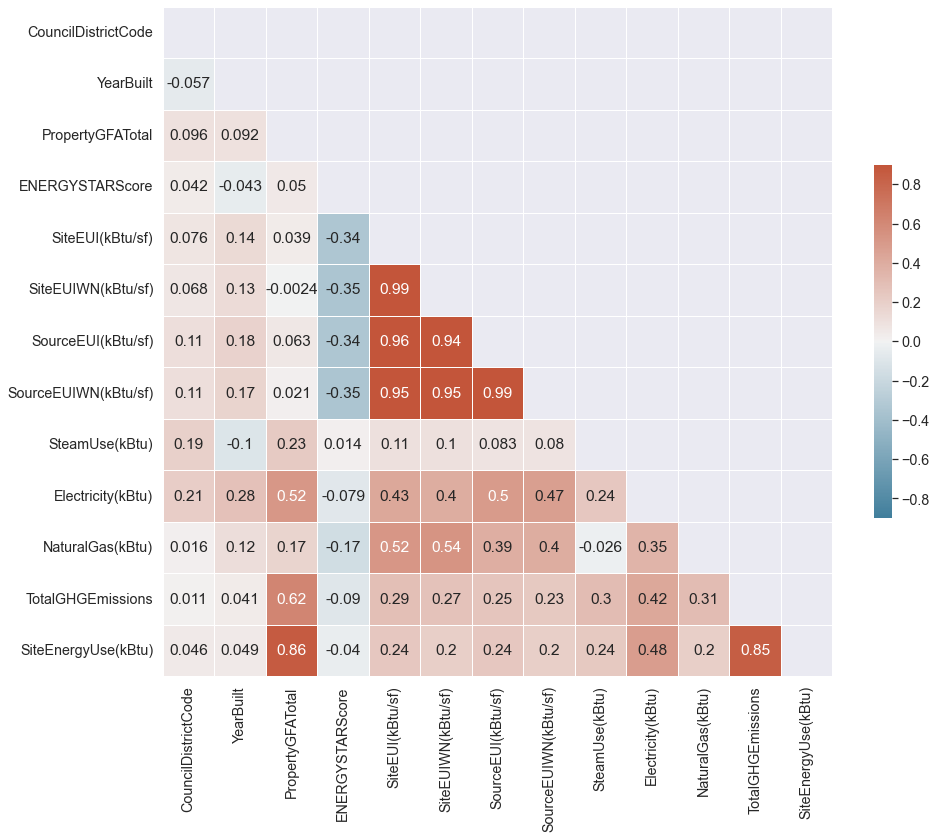

In [473]:
sns.set_theme(style="white")
plt.figure(figsize=(15,13))
Xy_train = pd.concat([X_train,y_train],axis =1)
corr = Xy_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set(font_scale=1.3)
sns.heatmap(corr, mask=mask, annot = True, fmt='.2g',cmap= cmap, vmax=.9, vmin=-0.9,center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Certaines variables quantitative semblent corrélées plus fortement à d'autres.  

Effectuons des tests statistiques pour tester la significativité des valeurs du coefficient de Pearson. Posons les hypothèses :

 - H0 : Variables indépendantes si p-value > a%
 - H1 : Variables non indépendantes si p-value < a%

On choisira a = 5 par défaut.

Calculons maintenant les p-values.

In [474]:
seuil_corr = 0.8
a = 0.05
corr_pd = []
for col in corr:
    for row in corr:
        corr_ = corr.loc[row,col]
        if corr_ not in corr_pd:
            if (abs(corr_) > seuil_corr) & (corr_ < 1):
                corr_pd.append(corr_)
                p_value = pearsonr(Xy_train[row],Xy_train[col])[1]
                if p_value < a:
                    print('Les variables','\033[1m' + row + '\033[0m','et','\033[1m' +col+'\033[0m','sont corrélées (',round(corr_,2),'), la p_value étant de',round(p_value,5),'.')

Les variables SiteEnergyUse(kBtu) et PropertyGFATotal sont corrélées ( 0.86 ), la p_value étant de 0.0 .
Les variables SiteEUIWN(kBtu/sf) et SiteEUI(kBtu/sf) sont corrélées ( 0.99 ), la p_value étant de 0.0 .
Les variables SourceEUI(kBtu/sf) et SiteEUI(kBtu/sf) sont corrélées ( 0.96 ), la p_value étant de 0.0 .
Les variables SourceEUIWN(kBtu/sf) et SiteEUI(kBtu/sf) sont corrélées ( 0.95 ), la p_value étant de 0.0 .
Les variables SourceEUI(kBtu/sf) et SiteEUIWN(kBtu/sf) sont corrélées ( 0.94 ), la p_value étant de 0.0 .
Les variables SourceEUIWN(kBtu/sf) et SiteEUIWN(kBtu/sf) sont corrélées ( 0.95 ), la p_value étant de 0.0 .
Les variables SourceEUIWN(kBtu/sf) et SourceEUI(kBtu/sf) sont corrélées ( 0.99 ), la p_value étant de 0.0 .
Les variables SiteEnergyUse(kBtu) et TotalGHGEmissions sont corrélées ( 0.85 ), la p_value étant de 0.0 .


Plusieurs conclusions peuvent être tirées de ces résultats.

Tout d'abord, les deux targets sélectionnées semblent corrélées à au moins une des variables explicatives (PropertyGFATotal), ce qui confirme qu'il est intéressant d'utiliser le jeu de données sélectionné pour les prédire.

Ensuite, les variables et leur version Weather Normalized (WN) semblent très corrélées entre elles. Il serait sans doute intéressant de ne garder qu'une version. Je choisis de garder les valeurs WN, normalisées sur 30 ans avec la météo.

Enfin, les variables SiteEUIWN(kBtu/sf) et SourceEUIWN(kBtu/sf) semblent également très corrélées. Je choisis de laisser de côté SouceEUIWN(kBtu/sf).

In [475]:
var_corr = ['SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)']
X_train = X_train.drop(var_corr,axis = 1)
X_test = X_test.drop(var_corr,axis = 1)

# <a class="anchor" id="chapter4">IV. Préparation des données</a>

Finalement, les variables sont normalisées et les variables catégorielles sont binarisées.
Les jeu de données sont sauvées, avec les targets en linéaires et semi-log. 

In [476]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler
import csv

def preparation (X_train,X_test,y_train,y_test):
    
    #BINARISATION DES VARIABLES CATEGORIELLES
    
    var_cat = X_train.select_dtypes('object').columns #liste des variables catégorielles
    
    #Convert to dict
    X_dict_train = X_train[var_cat].to_dict(orient='records')
    X_dict_test = X_test[var_cat].to_dict(orient='records')
        
    v = DictVectorizer(sparse = False)
    
    #Application de DictVectorizer
    X_bin_train = v.fit_transform(X_dict_train)
    X_bin_test = v.transform(X_dict_test)
    
    #Ajout nouvelles variables dans df de base
    X_bin_pd_train = pd.DataFrame(X_bin_train,columns = v.get_feature_names(), index = X_train.index)
    X_train = X_train.drop(var_cat,axis = 1)
    X_train = pd.concat([X_train,X_bin_pd_train],axis=1)
    
    X_bin_pd_test = pd.DataFrame(X_bin_test,columns = v.get_feature_names(), index = X_test.index)
    X_test = X_test.drop(var_cat,axis = 1)
    X_test = pd.concat([X_test,X_bin_pd_test],axis=1)
    
    
    
    #SCALING
    
    scaler = MinMaxScaler()
    X_train = pd.DataFrame(data = scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
    X_test = pd.DataFrame(data = scaler.transform(X_test), columns = X_test.columns, index = X_test.index)
    
    
    
    #TARGETS EN LOG
    
    y_test_log = np.log(y_test)
    y_train_log = np.log(y_train)
    
    
    
    #ECRITURE CSV
    
    X_train.to_csv('X_train.csv')
    X_test.to_csv('X_test.csv')
    y_train.to_csv('y_train.csv')
    y_test.to_csv('y_test.csv')
    
    y_train_log.to_csv('y_train_log.csv')
    y_test_log.to_csv('y_test_log.csv')
    
    return X_train, X_test, y_train, y_test, y_train_log, y_test_log

In [477]:
X_train,X_test,y_train,y_test, y_train_log, y_test_log = preparation(X_train,X_test,y_train,y_test)